<a href="https://colab.research.google.com/github/Sudiptermux/INFOSYS-_INTERNSHIP-OIL_SPILL_DETECTION-/blob/main/Oil_Spill_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!apt install p7zip-full

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
import albumentations as A

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import os

IMAGE_DIR = "/content/drive/MyDrive/images"
MASK_DIR = "/content/drive/MyDrive/masks"
FILTERED_IMAGE_DIR = "/content/drive/MyDrive/new_filtered_images"  # Define filtered images path here

print("Total Images:", len(os.listdir(IMAGE_DIR)))
print("Total Masks:", len(os.listdir(MASK_DIR)))

image_files = sorted(os.listdir(IMAGE_DIR))
mask_files = sorted(os.listdir(MASK_DIR))

print("First 5 Images:", image_files[:5])
print("First 5 Masks:", mask_files[:5])



Total Images: 811
Total Masks: 811
First 5 Images: ['Oil (1).jpg', 'Oil (10).jpg', 'Oil (100).jpg', 'Oil (1000).jpg', 'Oil (1001).jpg']
First 5 Masks: ['Oil (1).png', 'Oil (10).png', 'Oil (100).png', 'Oil (1000).png', 'Oil (1001).png']


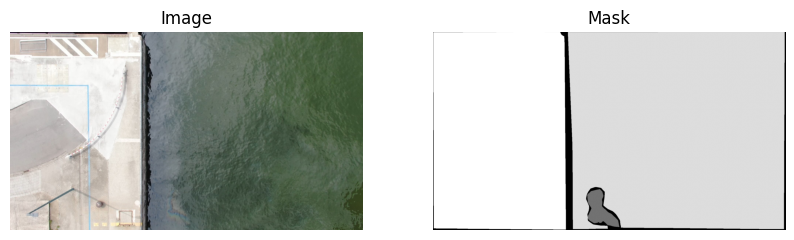

In [8]:
# Pick one sample to visualize
idx = 0
image_path = os.path.join(IMAGE_DIR, image_files[idx])
mask_path = os.path.join(MASK_DIR, mask_files[idx])

# Load
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR → RGB
mask = cv2.imread(mask_path, 0)  # Load mask in grayscale

# Plot
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(image)
plt.title("Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mask, cmap="gray")
plt.title("Mask")
plt.axis("off")

plt.show()

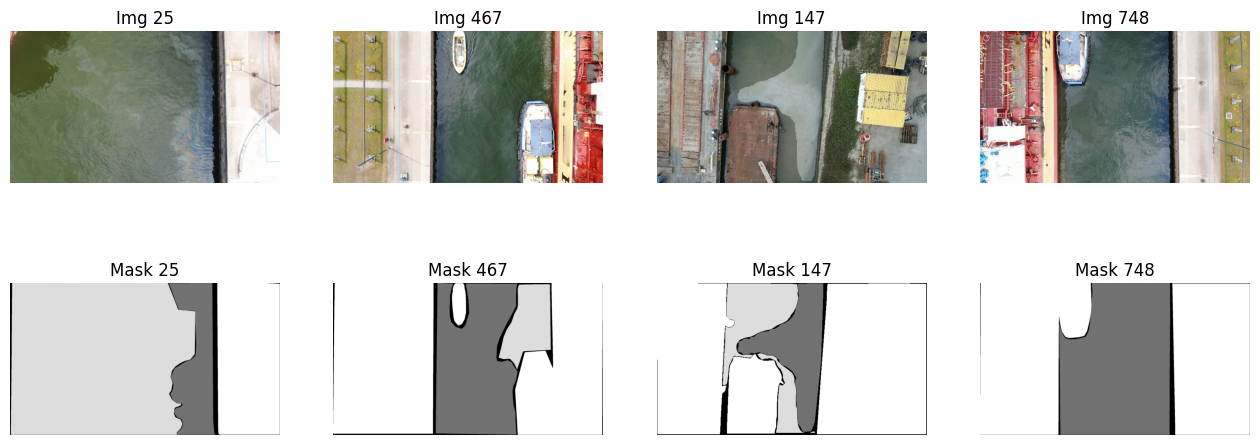

In [9]:
import random

# Number of samples to visualize
n = 4

# Randomly select n indices
indices = random.sample(range(len(image_files)), n)
plt.figure(figsize=(4 * n, 6))

for i, idx in enumerate(indices):
    img_path = os.path.join(IMAGE_DIR, image_files[idx])
    mask_path = os.path.join(MASK_DIR, mask_files[idx])

    # Load image in RGB
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    # Load mask in grayscale
    mask = cv2.imread(mask_path, 0)

    # Show image
    plt.subplot(2, n, i + 1)
    plt.imshow(img)
    plt.title(f"Img {idx}")
    plt.axis("off")

    # Show mask
    plt.subplot(2, n, n + i + 1)
    plt.imshow(mask, cmap="gray")
    plt.title(f"Mask {idx}")
    plt.axis("off")

plt.show()


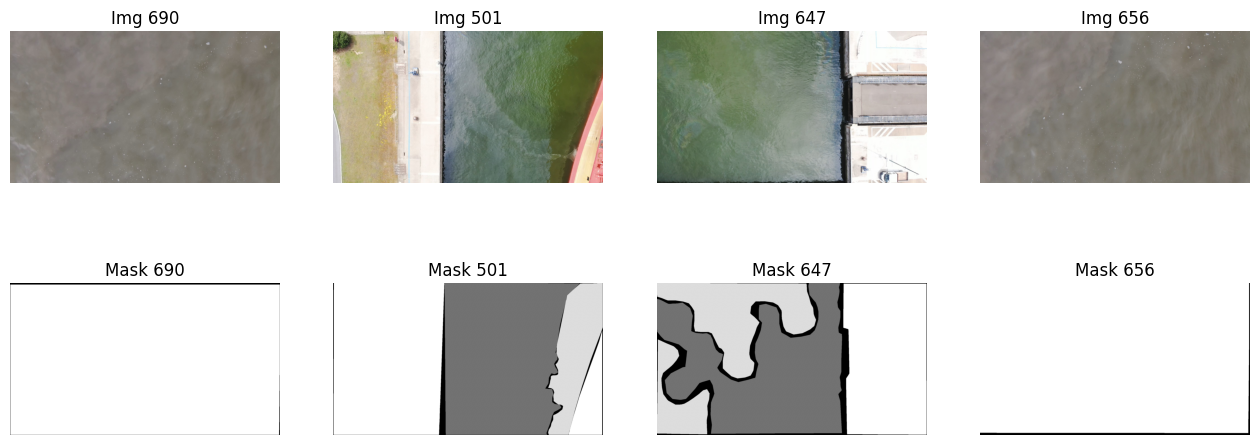

In [10]:
import random

# Number of samples to visualize
n = 4

# Randomly select n indices
indices = random.sample(range(len(image_files)), n)
plt.figure(figsize=(4 * n, 6))

for i, idx in enumerate(indices):
    img_path = os.path.join(IMAGE_DIR, image_files[idx])
    mask_path = os.path.join(MASK_DIR, mask_files[idx])

    # Load image in RGB
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    # Load mask in grayscale
    mask = cv2.imread(mask_path, 0)

    # Normalize image and mask to [0,1]
    img = img.astype('float32') / 255.0
    mask = mask.astype('float32') / 255.0

    # Show normalized image
    plt.subplot(2, n, i + 1)
    plt.imshow(img)
    plt.title(f"Img {idx}")
    plt.axis("off")

    # Show normalized mask
    plt.subplot(2, n, n + i + 1)
    plt.imshow(mask, cmap="gray")
    plt.title(f"Mask {idx}")
    plt.axis("off")

plt.show()

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


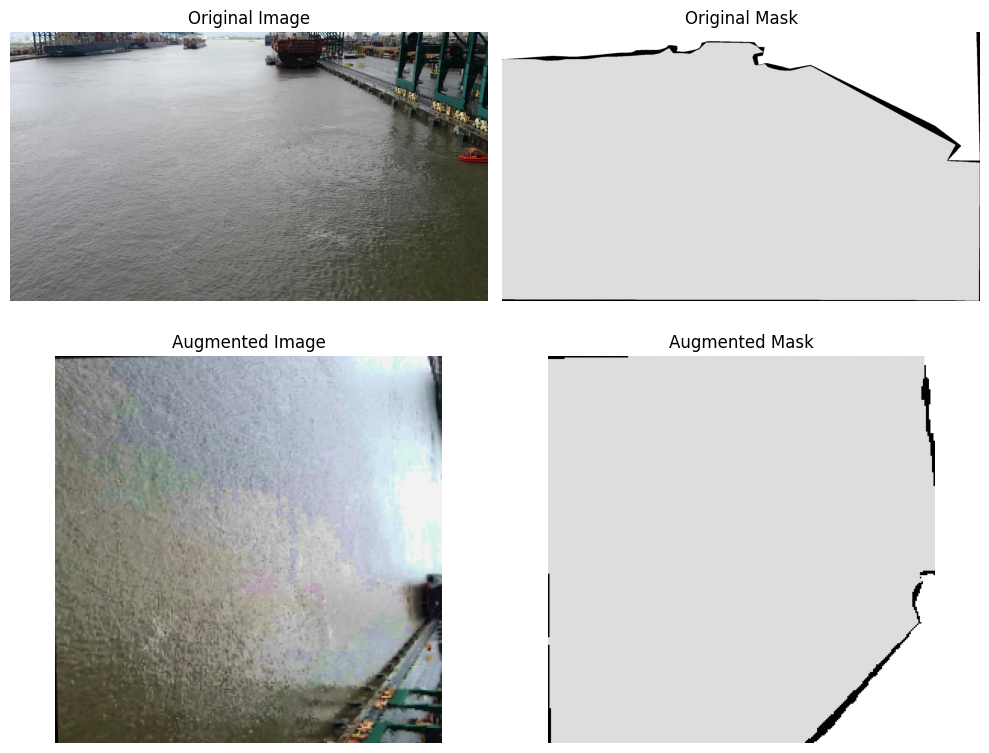

In [11]:
import albumentations as A

# Define augmentation
transform = A.Compose([
   A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=25, p=0.5),
    A.RandomBrightnessContrast(p=0.4),
    A.HueSaturationValue(hue_shift_limit=15, sat_shift_limit=25, val_shift_limit=15, p=0.4),
    A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0))
])


# Apply augmentation to all image-mask pairs
augmented_images = []
augmented_masks = []

for img_file, mask_file in zip(image_files, mask_files):
    img_path = os.path.join(IMAGE_DIR, img_file)
    mask_path = os.path.join(MASK_DIR, mask_file)

    image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, 0)

    augmented = transform(image=image, mask=mask)
    augmented_images.append(augmented['image'])
    augmented_masks.append(augmented['mask'])

# Visualize augmentation for one random pair
idx = random.randint(0, len(augmented_images)-1)

plt.figure(figsize=(10, 8))

# Original
orig_img_path = os.path.join(IMAGE_DIR, image_files[idx])
orig_mask_path = os.path.join(MASK_DIR, mask_files[idx])
orig_img = cv2.cvtColor(cv2.imread(orig_img_path), cv2.COLOR_BGR2RGB)
orig_mask = cv2.imread(orig_mask_path, 0)

plt.subplot(2, 2, 1)
plt.imshow(orig_img)
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(orig_mask, cmap='gray')
plt.title('Original Mask')
plt.axis('off')

# Augmented
plt.subplot(2, 2, 3)
plt.imshow(augmented_images[idx])
plt.title('Augmented Image')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(augmented_masks[idx], cmap='gray')
plt.title('Augmented Mask')
plt.axis('off')

plt.tight_layout()
plt.show()


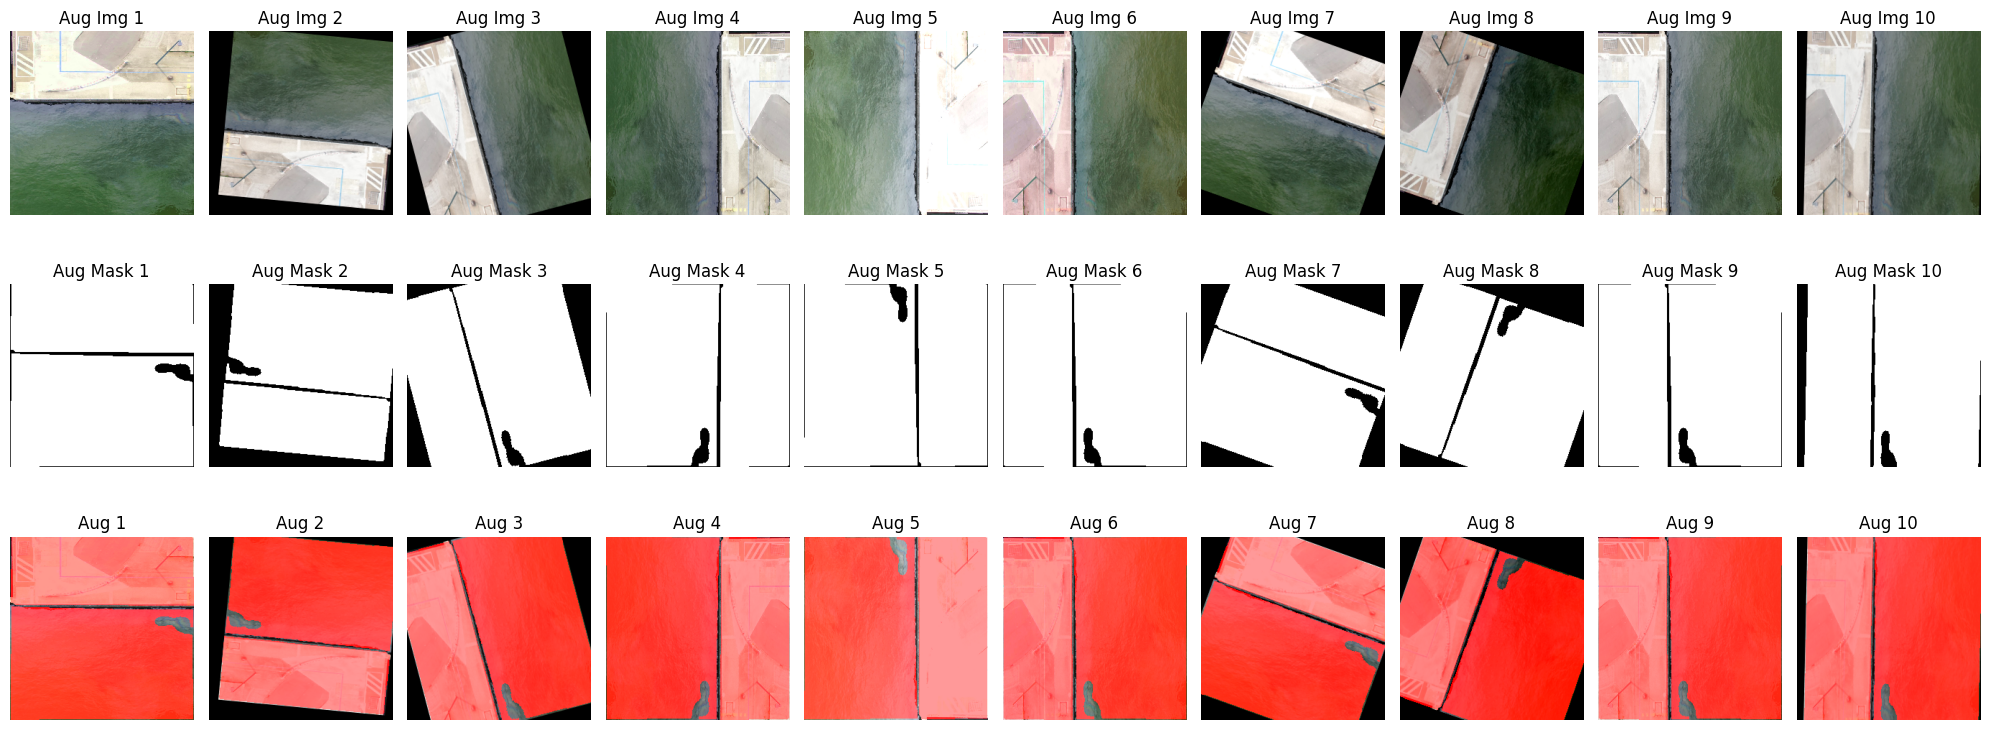

In [12]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

# Number of augmentations to show
num_augs = 10

# Pick one image and mask (e.g., index 0)
idx = 0
img_path = os.path.join(IMAGE_DIR, image_files[idx])
mask_path = os.path.join(MASK_DIR, mask_files[idx])

image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path, 0)

# Convert mask to binary
mask = (mask > 127).astype(np.uint8)

# Function to overlay mask on image
def overlay_mask(img, msk, color=(255, 0, 0), alpha=0.4):
    overlay = img.copy()
    overlay[msk == 1] = color
    return cv2.addWeighted(img, 1 - alpha, overlay, alpha, 0)

plt.figure(figsize=(20, 8))  # Height for 3 rows

for i in range(num_augs):
    augmented = transform(image=image, mask=mask)  # Apply augmentation
    aug_img, aug_mask = augmented['image'], augmented['mask']

    # Row 1: Augmented image
    plt.subplot(3, num_augs, i + 1)
    plt.imshow(aug_img)
    plt.title(f'Aug Img {i+1}')
    plt.axis('off')

    # Row 2: Augmented mask
    plt.subplot(3, num_augs, num_augs + i + 1)
    plt.imshow(aug_mask, cmap='gray')
    plt.title(f'Aug Mask {i+1}')
    plt.axis('off')

    # Row 3: Overlay mask
    blended = overlay_mask(aug_img, aug_mask)
    plt.subplot(3, num_augs, 2*num_augs + i + 1)
    plt.imshow(blended)
    plt.title(f'Aug {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [13]:
import cv2
import os
from tqdm import tqdm

# --- Faster Filter Script: Using the Bilateral Filter ---

# Define your input and output directories
IMAGE_DIR = "/content/drive/MyDrive/images"
FILTERED_IMAGE_DIR = "/content/drive/MyDrive/new_filtered_images"

print(f"Applying Bilateral Filter. Output will be saved to: {FILTERED_IMAGE_DIR}")
os.makedirs(FILTERED_IMAGE_DIR, exist_ok=True)

# Get the list of images to process
image_files = os.listdir(IMAGE_DIR)

# Loop through all original images with a progress bar
for img_file in tqdm(image_files, desc="Filtering Images"):
    img_path = os.path.join(IMAGE_DIR, img_file)

    # Load the image in color
    img_color = cv2.imread(img_path)

    if img_color is None:
        print(f"\nWarning: Could not read image {img_path}. Skipping.")
        continue

    # --- THIS IS THE CHANGE ---
    # We are now using the much faster cv2.bilateralFilter
    # Parameters are: (image, diameter_of_pixel_neighborhood, color_sigma, space_sigma)
    filtered_img = cv2.bilateralFilter(img_color, d=9, sigmaColor=75, sigmaSpace=75)

    # Save the new, cleaned color image to the new directory
    save_path = os.path.join(FILTERED_IMAGE_DIR, img_file)
    cv2.imwrite(save_path, filtered_img)

print(f"\nFiltering complete. Your cleaned color images are saved in: {FILTERED_IMAGE_DIR}")

Applying Bilateral Filter. Output will be saved to: /content/drive/MyDrive/new_filtered_images


Filtering Images: 100%|██████████| 811/811 [16:32<00:00,  1.22s/it]


Filtering complete. Your cleaned color images are saved in: /content/drive/MyDrive/new_filtered_images


Dataset created and split successfully.
Train dataset size: 648
Validation dataset size: 163

Pie chart is showing the dataset split and saved as 'dataset_split_pie_chart.png'.


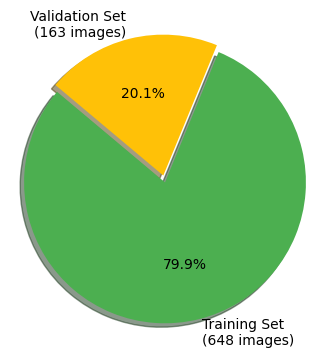

In [14]:
import torch
from torch.utils.data import Dataset, random_split
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# --- DATASET CLASS ---
class OilSpillDataset(Dataset):

    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Binarize the mask: any pixel value > 127 becomes 1, otherwise it's 0.
        mask = (mask > 127).astype(np.float32)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        image = torch.tensor(image.transpose(2, 0, 1), dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32)
        return image, mask

# --- CREATE AND SPLIT THE DATASET ---
# This assumes your FILTERED_IMAGE_DIR, MASK_DIR, and transform variables are already defined
dataset = OilSpillDataset(FILTERED_IMAGE_DIR, MASK_DIR, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"Dataset created and split successfully.")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")




# Plotting a pie chart
sizes = [train_size, val_size]
labels = [f'Training Set\n({train_size} images)', f'Validation Set\n({val_size} images)']
colors = ['#4CAF50', '#FFC107']
explode = (0.05, 0)


plt.figure(figsize=(4, 4))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.savefig('dataset_split_pie_chart.png')

print("\nPie chart is showing the dataset split and saved as 'dataset_split_pie_chart.png'.")

/tmp/ipython-input-966787511.py:42: RuntimeWarning: invalid value encountered in sqrt
  spill_std = np.sqrt(spill_var)
/tmp/ipython-input-966787511.py:46: RuntimeWarning: invalid value encountered in sqrt
  nonspill_std = np.sqrt(nonspill_var)


Spill region - Mean: 141.39, Std Dev: nan
Non-spill region - Mean: 103.03, Std Dev: nan


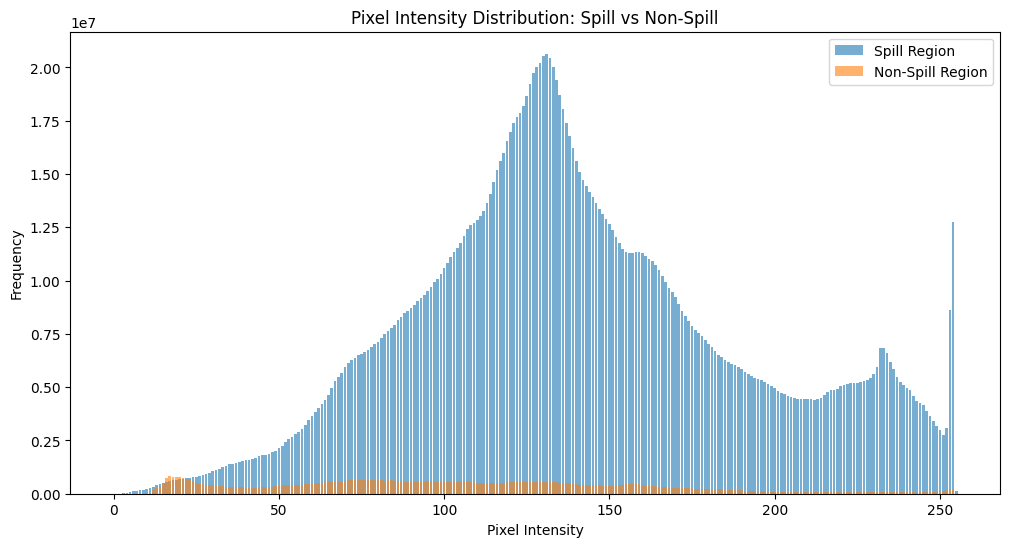

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

spill_sum = 0
spill_sum_sq = 0
spill_count = 0

nonspill_sum = 0
nonspill_sum_sq = 0
nonspill_count = 0

# For histogram
spill_hist = np.zeros(256)
nonspill_hist = np.zeros(256)

for img_file, mask_file in zip(sorted(os.listdir(FILTERED_IMAGE_DIR)), sorted(os.listdir(MASK_DIR))):
    img_path = os.path.join(FILTERED_IMAGE_DIR, img_file)
    mask_path = os.path.join(MASK_DIR, mask_file)

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Spill pixels
    spill_pixels = img[mask > 0]
    spill_sum += np.sum(spill_pixels)
    spill_sum_sq += np.sum(spill_pixels**2)
    spill_count += spill_pixels.size
    spill_hist += np.bincount(spill_pixels, minlength=256)

    # Non-spill pixels
    nonspill_pixels = img[mask == 0]
    nonspill_sum += np.sum(nonspill_pixels)
    nonspill_sum_sq += np.sum(nonspill_pixels**2)
    nonspill_count += nonspill_pixels.size
    nonspill_hist += np.bincount(nonspill_pixels, minlength=256)

# Calculate means and stddevs
spill_mean = spill_sum / spill_count
spill_var = (spill_sum_sq / spill_count) - (spill_mean ** 2)
spill_std = np.sqrt(spill_var)

nonspill_mean = nonspill_sum / nonspill_count
nonspill_var = (nonspill_sum_sq / nonspill_count) - (nonspill_mean ** 2)
nonspill_std = np.sqrt(nonspill_var)

print(f"Spill region - Mean: {spill_mean:.2f}, Std Dev: {spill_std:.2f}")
print(f"Non-spill region - Mean: {nonspill_mean:.2f}, Std Dev: {nonspill_std:.2f}")

# Plot histograms
plt.figure(figsize=(12, 6))
plt.bar(range(256), spill_hist, alpha=0.6, label='Spill Region')
plt.bar(range(256), nonspill_hist, alpha=0.6, label='Non-Spill Region')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Pixel Intensity Distribution: Spill vs Non-Spill')
plt.legend()
plt.show()


In [16]:
# Install the required library first
!pip install -q segmentation-models-pytorch

import segmentation_models_pytorch as smp

# This new code replaces your entire previous UNET class definition.
# It creates a U-Net with a powerful ResNet34 encoder pre-trained on ImageNet,
# which is the most effective way to improve your model's accuracy.
model = smp.Unet(
    encoder_name="resnet34",        # Use the popular and effective ResNet34 backbone
    encoder_weights="imagenet",     # Load weights pre-trained on ImageNet for a head start
    in_channels=3,                  # Your input images have 3 channels
    classes=1,                      # Your output is a single mask
)

print("U-Net with pre-trained ResNet34 encoder created successfully.")

U-Net with pre-trained ResNet34 encoder created successfully.


In [17]:
import torch
import torch.nn as nn

class DiceBCELoss(nn.Module):
    def __init__(self, bce_weight=0.5):
        super(DiceBCELoss, self).__init__()
        self.bce_weight = bce_weight
        self.bce_loss = nn.BCEWithLogitsLoss()

    def dice_loss_func(self, inputs, targets, smooth=1e-6):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return 1 - dice

    def forward(self, inputs, targets):
        if targets.dim() == 3:
             targets_bce = targets.float().unsqueeze(1)
        else:
             targets_bce = targets.float()

        bce = self.bce_loss(inputs, targets_bce)
        dice = self.dice_loss_func(inputs, targets)
        total_loss = self.bce_weight * bce + (1 - self.bce_weight) * dice
        return total_loss

print("DiceBCELoss function defined.")

DiceBCELoss function defined.


In [19]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm


# -- Final Hyperparameters & Setup --
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 50
NUM_WORKERS = 2
# -- Initialization --
# This assumes the 'model' variable (the smp.Unet) is already defined and moved to the DEVICE.
model.to(DEVICE)
loss_fn = DiceBCELoss() # Your loss function from a previous cell is still used
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# --- ADDED: Learning Rate Scheduler ---
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

# --- Helper Functions (with manual IoU) ---

# This is our manual calculation function
def calculate_iou_score(preds, targets, smooth=1e-6):
    preds = preds.view(-1)
    targets = targets.view(-1)
    intersection = (preds * targets).sum()
    union = (preds + targets).sum() - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.item()

def train_one_epoch(loader, model, optimizer, loss_fn):
    loop = tqdm(loader, leave=True)
    model.train()
    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.to(device=DEVICE)
        predictions = model(data)
        loss = loss_fn(predictions, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loop.set_postfix(loss=loss.item())

def check_accuracy(loader, model, device="cuda"):
    total_iou_score = 0
    num_batches = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            preds_binary = (torch.sigmoid(model(x)) > 0.5).float()

            # We now call our manual function instead of the torchmetrics object
            total_iou_score += calculate_iou_score(preds_binary, y)
            num_batches += 1

    avg_iou = total_iou_score / num_batches
    print(f"Validation IoU: {avg_iou:.4f}")
    return avg_iou

# --- Main Training Loop with Early Stopping ---
print(f"--- Starting Training on {DEVICE.upper()} ---")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

best_val_iou = -1.0
epochs_no_improve = 0
patience = 7 # Increased patience for a more powerful model

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}]")
    train_one_epoch(train_loader, model, optimizer, loss_fn)
    val_iou = check_accuracy(val_loader, model, device=DEVICE)

    if val_iou > best_val_iou:
        best_val_iou = val_iou
        epochs_no_improve = 0
        checkpoint = {"state_dict": model.state_dict()}
        # Make sure to save with the correct name for this model
        torch.save(checkpoint, "/content/drive/MyDrive/best_model_custom_unet.pth.tar")
        print(f"✓ Model Saved! New best IoU: {best_val_iou:.4f}")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s).")

    scheduler.step()

    if epochs_no_improve >= patience:
        print(f"\nEarly stopping triggered after {epoch+1} epochs.")
        break


--- Starting Training on CUDA ---

Epoch [1/50]


100%|██████████| 41/41 [00:33<00:00,  1.23it/s, loss=0.305]


Validation IoU: 0.7931
✓ Model Saved! New best IoU: 0.7931

Epoch [2/50]


100%|██████████| 41/41 [00:33<00:00,  1.23it/s, loss=0.193]


Validation IoU: 0.8252
✓ Model Saved! New best IoU: 0.8252

Epoch [3/50]


100%|██████████| 41/41 [00:36<00:00,  1.11it/s, loss=0.182]


Validation IoU: 0.8639
✓ Model Saved! New best IoU: 0.8639

Epoch [4/50]


100%|██████████| 41/41 [00:35<00:00,  1.15it/s, loss=0.255]


Validation IoU: 0.8630
No improvement for 1 epoch(s).

Epoch [5/50]


100%|██████████| 41/41 [00:32<00:00,  1.26it/s, loss=0.236]


Validation IoU: 0.8771
✓ Model Saved! New best IoU: 0.8771

Epoch [6/50]


100%|██████████| 41/41 [00:35<00:00,  1.17it/s, loss=0.175]


Validation IoU: 0.8808
✓ Model Saved! New best IoU: 0.8808

Epoch [7/50]


100%|██████████| 41/41 [00:35<00:00,  1.14it/s, loss=0.18]


Validation IoU: 0.8789
No improvement for 1 epoch(s).

Epoch [8/50]


100%|██████████| 41/41 [00:32<00:00,  1.26it/s, loss=0.176]


Validation IoU: 0.8697
No improvement for 2 epoch(s).

Epoch [9/50]


100%|██████████| 41/41 [00:34<00:00,  1.20it/s, loss=0.163]


Validation IoU: 0.8933
✓ Model Saved! New best IoU: 0.8933

Epoch [10/50]


100%|██████████| 41/41 [00:35<00:00,  1.15it/s, loss=0.256]


Validation IoU: 0.8982
✓ Model Saved! New best IoU: 0.8982

Epoch [11/50]


100%|██████████| 41/41 [00:35<00:00,  1.14it/s, loss=0.138]


Validation IoU: 0.9162
✓ Model Saved! New best IoU: 0.9162

Epoch [12/50]


100%|██████████| 41/41 [00:36<00:00,  1.11it/s, loss=0.25]


Validation IoU: 0.9213
✓ Model Saved! New best IoU: 0.9213

Epoch [13/50]


100%|██████████| 41/41 [00:36<00:00,  1.11it/s, loss=0.174]


Validation IoU: 0.9224
✓ Model Saved! New best IoU: 0.9224

Epoch [14/50]


100%|██████████| 41/41 [00:36<00:00,  1.12it/s, loss=0.0806]


Validation IoU: 0.9249
✓ Model Saved! New best IoU: 0.9249

Epoch [15/50]


100%|██████████| 41/41 [00:37<00:00,  1.08it/s, loss=0.0761]


Validation IoU: 0.9271
✓ Model Saved! New best IoU: 0.9271

Epoch [16/50]


100%|██████████| 41/41 [00:35<00:00,  1.15it/s, loss=0.0705]


Validation IoU: 0.9108
No improvement for 1 epoch(s).

Epoch [17/50]


100%|██████████| 41/41 [00:33<00:00,  1.24it/s, loss=0.0925]


Validation IoU: 0.9174
No improvement for 2 epoch(s).

Epoch [18/50]


100%|██████████| 41/41 [00:33<00:00,  1.22it/s, loss=0.0892]


Validation IoU: 0.9338
✓ Model Saved! New best IoU: 0.9338

Epoch [19/50]


100%|██████████| 41/41 [00:36<00:00,  1.11it/s, loss=0.0997]


Validation IoU: 0.9276
No improvement for 1 epoch(s).

Epoch [20/50]


100%|██████████| 41/41 [00:32<00:00,  1.25it/s, loss=0.102]


Validation IoU: 0.9268
No improvement for 2 epoch(s).

Epoch [21/50]


100%|██████████| 41/41 [00:35<00:00,  1.16it/s, loss=0.145]


Validation IoU: 0.9322
No improvement for 3 epoch(s).

Epoch [22/50]


100%|██████████| 41/41 [00:34<00:00,  1.19it/s, loss=0.197]


Validation IoU: 0.9304
No improvement for 4 epoch(s).

Epoch [23/50]


100%|██████████| 41/41 [00:33<00:00,  1.21it/s, loss=0.0693]


Validation IoU: 0.9290
No improvement for 5 epoch(s).

Epoch [24/50]


100%|██████████| 41/41 [00:33<00:00,  1.21it/s, loss=0.0651]


Validation IoU: 0.9369
✓ Model Saved! New best IoU: 0.9369

Epoch [25/50]


100%|██████████| 41/41 [00:36<00:00,  1.12it/s, loss=0.32]


Validation IoU: 0.9381
✓ Model Saved! New best IoU: 0.9381

Epoch [26/50]


100%|██████████| 41/41 [00:36<00:00,  1.12it/s, loss=0.0684]


Validation IoU: 0.9304
No improvement for 1 epoch(s).

Epoch [27/50]


100%|██████████| 41/41 [00:34<00:00,  1.20it/s, loss=0.182]


Validation IoU: 0.9328
No improvement for 2 epoch(s).

Epoch [28/50]


100%|██████████| 41/41 [00:34<00:00,  1.17it/s, loss=0.0885]


Validation IoU: 0.9062
No improvement for 3 epoch(s).

Epoch [29/50]


100%|██████████| 41/41 [00:32<00:00,  1.26it/s, loss=0.11]


Validation IoU: 0.9089
No improvement for 4 epoch(s).

Epoch [30/50]


100%|██████████| 41/41 [00:32<00:00,  1.25it/s, loss=0.0357]


Validation IoU: 0.9082
No improvement for 5 epoch(s).

Epoch [31/50]


100%|██████████| 41/41 [00:32<00:00,  1.24it/s, loss=0.0958]


Validation IoU: 0.9416
✓ Model Saved! New best IoU: 0.9416

Epoch [32/50]


100%|██████████| 41/41 [00:35<00:00,  1.16it/s, loss=0.163]


Validation IoU: 0.9413
No improvement for 1 epoch(s).

Epoch [33/50]


100%|██████████| 41/41 [00:33<00:00,  1.24it/s, loss=0.0794]


Validation IoU: 0.9445
✓ Model Saved! New best IoU: 0.9445

Epoch [34/50]


100%|██████████| 41/41 [00:37<00:00,  1.08it/s, loss=0.0935]


Validation IoU: 0.9432
No improvement for 1 epoch(s).

Epoch [35/50]


100%|██████████| 41/41 [00:32<00:00,  1.26it/s, loss=0.0558]


Validation IoU: 0.9410
No improvement for 2 epoch(s).

Epoch [36/50]


100%|██████████| 41/41 [00:32<00:00,  1.24it/s, loss=0.0805]


Validation IoU: 0.9414
No improvement for 3 epoch(s).

Epoch [37/50]


100%|██████████| 41/41 [00:32<00:00,  1.26it/s, loss=0.0424]


Validation IoU: 0.9413
No improvement for 4 epoch(s).

Epoch [38/50]


100%|██████████| 41/41 [00:33<00:00,  1.24it/s, loss=0.0456]


Validation IoU: 0.9410
No improvement for 5 epoch(s).

Epoch [39/50]


100%|██████████| 41/41 [00:32<00:00,  1.26it/s, loss=0.0679]


Validation IoU: 0.9411
No improvement for 6 epoch(s).

Epoch [40/50]


100%|██████████| 41/41 [00:34<00:00,  1.19it/s, loss=0.0984]


Validation IoU: 0.9424
No improvement for 7 epoch(s).

Early stopping triggered after 40 epochs.


In [21]:
import torch

# --- 1. LOAD YOUR CUSTOM-BUILT MODEL ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize your custom UNET architecture
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=3,
    classes=1,
).to(DEVICE)

# Load the weights for the NEW custom model
MODEL_PATH = "/content/drive/MyDrive/best_model_custom_unet.pth.tar"
checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)
model.load_state_dict(checkpoint["state_dict"])
model.eval()

print(f"✓ Best custom model loaded successfully from: {MODEL_PATH}")

✓ Best custom model loaded successfully from: /content/drive/MyDrive/best_model_custom_unet.pth.tar


In [22]:
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)



# --- Define Manual Metric Functions ---
def calculate_dice_score(preds, targets, smooth=1e-6):
    preds = preds.view(-1)
    targets = targets.view(-1)
    intersection = (preds * targets).sum()
    return (2. * intersection + smooth) / (preds.sum() + targets.sum() + smooth)

def calculate_iou_score(preds, targets, smooth=1e-6):
    preds = preds.view(-1)
    targets = targets.view(-1)
    intersection = (preds * targets).sum()
    union = (preds + targets).sum() - intersection
    return (intersection + smooth) / (union + smooth)

# --- Evaluate on the Entire Validation Set ---
print("\nCalculating final scores for the custom model...")
total_iou, total_dice, num_batches = 0, 0, 0

with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        preds_binary = (torch.sigmoid(model(x)) > 0.5).float()

        total_iou += calculate_iou_score(preds_binary, y).item()
        total_dice += calculate_dice_score(preds_binary, y).item()
        num_batches += 1

avg_iou = total_iou / num_batches
avg_dice = total_dice / num_batches

print("\n--- Custom Model Performance ---")
print(f"Intersection over Union (IoU): {avg_iou*100:.2f}%")
print(f"Dice Score: {avg_dice*100:.2f}%")


Calculating final scores for the custom model...

--- Custom Model Performance ---
Intersection over Union (IoU): 94.45%
Dice Score: 97.13%



Generating predictions for visualization...


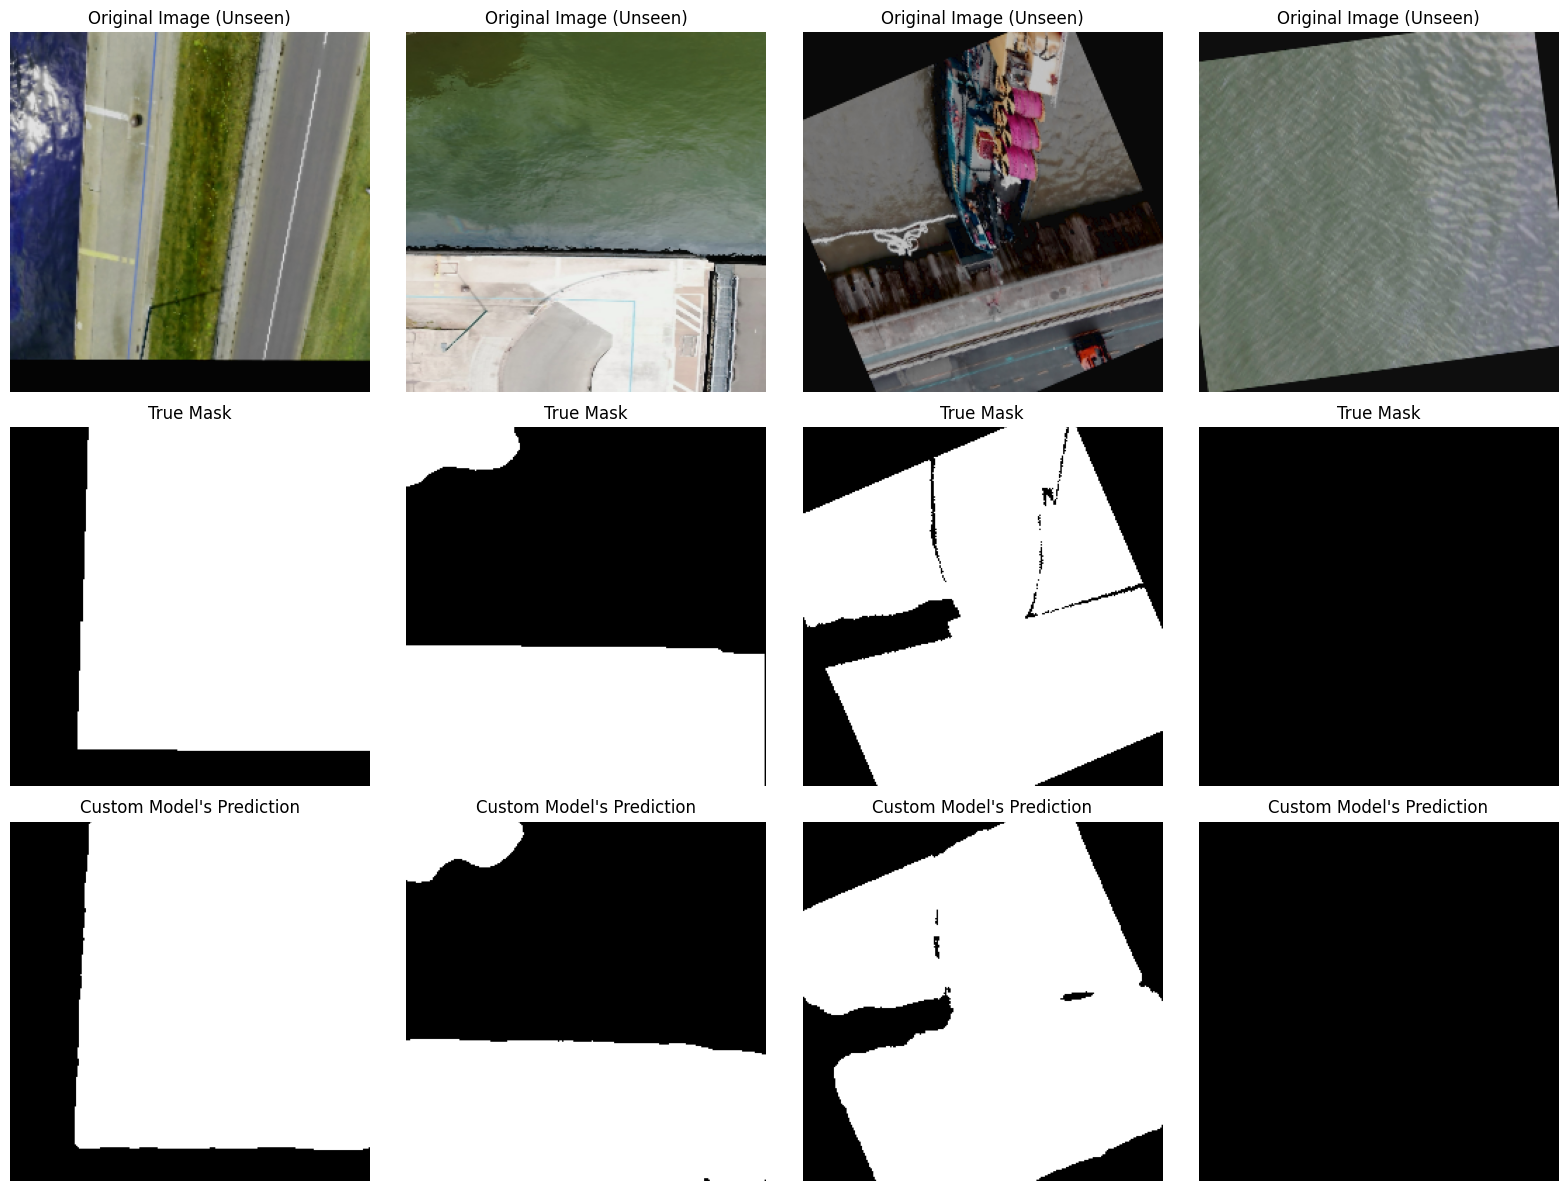

In [24]:

import matplotlib.pyplot as plt
import numpy as np

print("\nGenerating predictions for visualization...")
images, masks = next(iter(val_loader))
images = images.to(DEVICE)

plt.figure(figsize=(16, 12))
with torch.no_grad():
    preds_binary = (torch.sigmoid(model(images)) > 0.5).float()
    images_cpu, masks_cpu, preds_binary_cpu = images.cpu(), masks.cpu(), preds_binary.cpu()

    for i in range(min(len(images), 4)):
        plt.subplot(3, 4, i + 1)
        plt.imshow(np.transpose(images_cpu[i].numpy(), (1, 2, 0)))
        plt.title("Original Image (Unseen)")
        plt.axis("off")

        plt.subplot(3, 4, i + 5)
        plt.imshow(masks_cpu[i].squeeze(), cmap='gray')
        plt.title("True Mask")
        plt.axis("off")

        plt.subplot(3, 4, i + 9)
        plt.imshow(preds_binary_cpu[i].squeeze(), cmap='gray')
        plt.title("Custom Model's Prediction") # <-- The more specific title
        plt.axis("off")

plt.tight_layout()
plt.show()


Generating Error Analysis Maps...


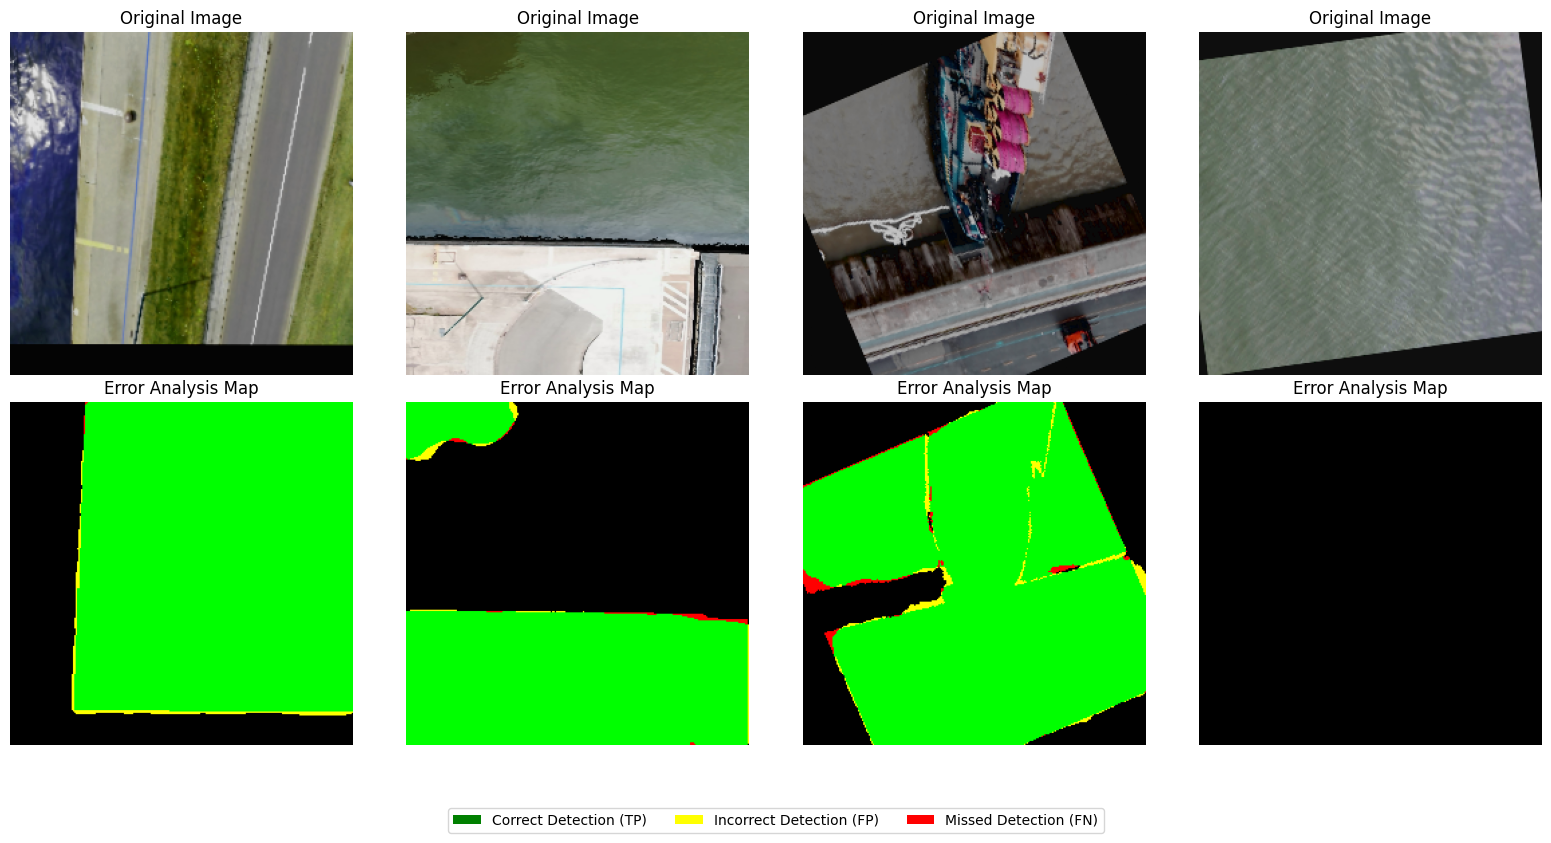

In [25]:
# --- ERROR ANALYSIS MAP ---
print("\nGenerating Error Analysis Maps...")
plt.figure(figsize=(16, 8))

for i in range(min(len(images), 4)):
    # Get the individual masks
    true_mask = masks_cpu[i].squeeze().numpy()
    pred_mask = preds_binary_cpu[i].squeeze().numpy()

    # Create an empty RGB image for the error map
    error_map = np.zeros((true_mask.shape[0], true_mask.shape[1], 3), dtype=np.float32)

    # Find True Positives, False Positives, False Negatives
    tp = (true_mask == 1) & (pred_mask == 1)
    fp = (true_mask == 0) & (pred_mask == 1)
    fn = (true_mask == 1) & (pred_mask == 0)

    # Color the pixels accordingly
    error_map[tp] = [0, 1, 0]  # Green for Correct Detections
    error_map[fp] = [1, 1, 0]  # Yellow for Incorrect Detections (False Positives)
    error_map[fn] = [1, 0, 0]  # Red for Missed Detections (False Negatives)

    # Plot the original image
    plt.subplot(2, 4, i + 1)
    plt.imshow(np.transpose(images_cpu[i].numpy(), (1, 2, 0)))
    plt.title("Original Image")
    plt.axis("off")

    # Plot the error map
    plt.subplot(2, 4, i + 5)
    plt.imshow(error_map)
    plt.title("Error Analysis Map")
    plt.axis("off")

# Create a legend for the error map colors
green_patch = plt.Rectangle((0, 0), 1, 1, fc="green")
yellow_patch = plt.Rectangle((0, 0), 1, 1, fc="yellow")
red_patch = plt.Rectangle((0, 0), 1, 1, fc="red")
plt.figlegend(handles=[green_patch, yellow_patch, red_patch],
              labels=['Correct Detection (TP)', 'Incorrect Detection (FP)', 'Missed Detection (FN)'],
              loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))

plt.tight_layout(rect=[0, 0.05, 1, 1]) # Adjust layout to make space for the legend
plt.show()

